# Use Implict Quantile Network to Play Pong

TensorFlow version

In [1]:
%matplotlib inline

import copy
import logging
import itertools
import sys

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
from gym.wrappers.atari_preprocessing import AtariPreprocessing
from gym.wrappers.frame_stack import FrameStack
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers
from tensorflow.keras import models

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

Environment

In [2]:
env = FrameStack(AtariPreprocessing(gym.make('PongNoFrameskip-v4')),
        num_stack=4)
env.env.env.unwrapped.np_random.seed(0) # set seed for noops
env.env.env.unwrapped.unwrapped.seed(0) # set seed for AtariEnv
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

00:00:52 [INFO] env: <AtariPreprocessing<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>
00:00:52 [INFO] action_space: Discrete(6)
00:00:52 [INFO] observation_space: : Box([[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], [[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 

Agent

In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = np.asarray(args, dtype=object)
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class Net(keras.Model):
    def __init__(self, action_n, sample_count, cosine_count):
        super().__init__()
        self.cosine_count = cosine_count
        self.conv = keras.Sequential([
                keras.layers.Permute((2, 3, 1), input_shape=(4, 84, 84)),
                layers.Conv2D(32, kernel_size=8, strides=4, activation=nn.relu),
                layers.Conv2D(64, kernel_size=4, strides=2, activation=nn.relu),
                layers.Conv2D(64, kernel_size=3, strides=1, activation=nn.relu),
                layers.Reshape((1, 3136))])
        self.emb = keras.Sequential([
                layers.Dense(3136, activation=nn.relu,
                input_shape=(sample_count, cosine_count))])
        self.fc = keras.Sequential([
                layers.Dense(512, activation=nn.relu),
                layers.Dense(action_n),
                layers.Permute((2, 1))])

    def call(self, input_tensor, cumprob_tensor):
        logit_tensor = self.conv(input_tensor)
        index_tensor = tf.range(1, self.cosine_count + 1, dtype=tf.float32)[
                np.newaxis, np.newaxis, :]
        cosine_tensor = tf.math.cos(index_tensor * np.pi * cumprob_tensor)
        emb_tensor = self.emb(cosine_tensor)
        prod_tensor = logit_tensor * emb_tensor
        output_tensor = self.fc(prod_tensor)
        return output_tensor

In [5]:
class Agent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        self.epsilon = 1.

        self.replayer = DQNReplayer(capacity=100000)

        self.sample_count = 8
        self.evaluate_net = self.build_net(action_n=self.action_n,
                sample_count=self.sample_count)
        self.target_net = self.build_net(action_n=self.action_n,
                sample_count=self.sample_count)
        
    def build_net(self, action_n, sample_count, cosine_count=64):
        net = Net(action_n, sample_count, cosine_count)
        loss = losses.Huber(reduction="none")
        optimizer = optimizers.Adam(0.0001)
        net.compile(loss=loss, optimizer=optimizer)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = tf.convert_to_tensor(np.array(observation)[np.newaxis],
                dtype=tf.float32)
        prob_tensor = tf.random.uniform((1, self.sample_count, 1))
        q_component_tensor = self.evaluate_net(state_tensor, prob_tensor)
        q_tensor = tf.reduce_mean(q_component_tensor, axis=2)
        action_tensor = tf.math.argmax(q_tensor, axis=1)
        actions = action_tensor.numpy()
        action = actions[0]
        if self.mode == 'train':
            if np.random.rand() < self.epsilon:
                action = np.random.randint(0, self.action_n)
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)
            if self.replayer.count >= 1024 and self.replayer.count % 10 == 0:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        average_weights = [(1. - learning_rate) * t + learning_rate * e for t, e
                in zip(target_net.get_weights(), evaluate_net.get_weights())]
        target_net.set_weights(average_weights)

    def learn(self):
        # replay
        batch_size = 32
        states, actions, rewards, next_states, dones = \
                self.replayer.sample(batch_size)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        reward_tensor = tf.convert_to_tensor(rewards[:, np.newaxis],
                dtype=tf.float32)
        done_tensor = tf.convert_to_tensor(dones[:, np.newaxis],
                dtype=tf.float32)
        next_state_tensor = tf.convert_to_tensor(next_states, dtype=tf.float32)

        # calculate target
        next_cumprob_tensor = tf.random.uniform((batch_size, self.sample_count, 1))
        next_q_component_tensor = self.evaluate_net(next_state_tensor,
                next_cumprob_tensor)
        next_q_tensor = tf.reduce_mean(next_q_component_tensor, axis=2)
        next_action_tensor = tf.math.argmax(next_q_tensor, axis=1)
        next_actions = next_action_tensor.numpy()
        next_cumprob_tensor = tf.random.uniform((batch_size, self.sample_count, 1))
        all_next_q_quantile_tensor = self.target_net(next_state_tensor,
                next_cumprob_tensor)
        indices = [[idx, next_action] for idx, next_action in
                enumerate(next_actions)]
        next_q_quantile_tensor = tf.gather_nd(all_next_q_quantile_tensor,
                indices)
        target_quantile_tensor = reward_tensor + self.gamma \
                * next_q_quantile_tensor * (1. - done_tensor)

        with tf.GradientTape() as tape:
            cumprob_tensor = tf.random.uniform((batch_size,
                    self.sample_count, 1))
            all_q_quantile_tensor = self.evaluate_net(state_tensor,
                    cumprob_tensor)
            indices = [[idx, action] for idx, action in enumerate(actions)]
            q_quantile_tensor = tf.gather_nd(all_q_quantile_tensor, indices)
            target_quantile_tensor = target_quantile_tensor[:, np.newaxis, :]
            q_quantile_tensor = q_quantile_tensor[:, :, np.newaxis]
            td_error_tensor = target_quantile_tensor - q_quantile_tensor
            abs_td_error_tensor = tf.math.abs(td_error_tensor)
            hubor_delta = 1.
            hubor_loss_tensor = tf.where(abs_td_error_tensor < hubor_delta,
                    0.5 * tf.square(td_error_tensor),
                    hubor_delta * (abs_td_error_tensor - 0.5 * hubor_delta))
            comparison_tensor = tf.cast(td_error_tensor < 0, dtype=tf.float32)
            quantile_regression_tensor = tf.math.abs(cumprob_tensor -
                    comparison_tensor)
            quantile_huber_loss_tensor = tf.reduce_mean(tf.reduce_sum(
                    hubor_loss_tensor * quantile_regression_tensor, axis=-1),
                    axis=1)
            loss_tensor = tf.reduce_mean(quantile_huber_loss_tensor)
        grads = tape.gradient(loss_tensor, self.evaluate_net.variables)
        self.evaluate_net.optimizer.apply_gradients(
                zip(grads, self.evaluate_net.variables))

        self.update_net(self.target_net, self.evaluate_net)

        self.epsilon = max(self.epsilon - 1e-5, 0.05)


agent = Agent(env)

Train & Test

In [6]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps

00:00:53 [INFO] ==== train ====
00:01:17 [DEBUG] train episode 0: reward = -18.00, steps = 1208
00:01:51 [DEBUG] train episode 1: reward = -19.00, steps = 981
00:02:24 [DEBUG] train episode 2: reward = -21.00, steps = 940
00:02:53 [DEBUG] train episode 3: reward = -21.00, steps = 819
00:03:30 [DEBUG] train episode 4: reward = -19.00, steps = 1037
00:04:02 [DEBUG] train episode 5: reward = -21.00, steps = 875
00:04:33 [DEBUG] train episode 6: reward = -21.00, steps = 851
00:05:07 [DEBUG] train episode 7: reward = -21.00, steps = 939
00:05:39 [DEBUG] train episode 8: reward = -20.00, steps = 875
00:06:10 [DEBUG] train episode 9: reward = -21.00, steps = 853
00:06:41 [DEBUG] train episode 10: reward = -21.00, steps = 852
00:07:15 [DEBUG] train episode 11: reward = -21.00, steps = 940
00:07:45 [DEBUG] train episode 12: reward = -21.00, steps = 848
00:08:14 [DEBUG] train episode 13: reward = -21.00, steps = 806
00:08:44 [DEBUG] train episode 14: reward = -20.00, steps = 836
00:09:17 [DEBUG]

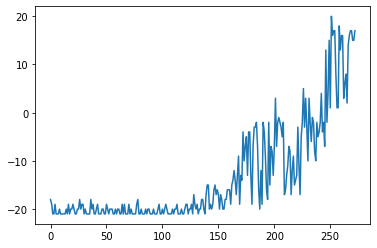

In [7]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-5:]) > 16.:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))